In [14]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

### 1. Импорт и загрузка

(np.float64(-0.5), np.float64(1199.5), np.float64(674.5), np.float64(-0.5))

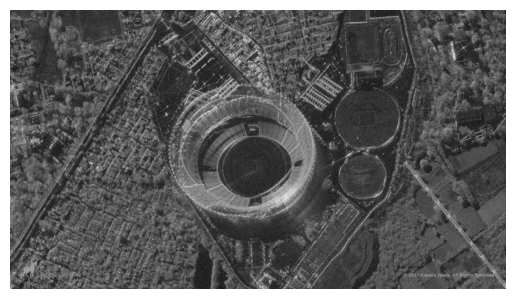

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.axis('off')


### 2. Исходное изображение и результаты добавления гауссовского и равномерного шума

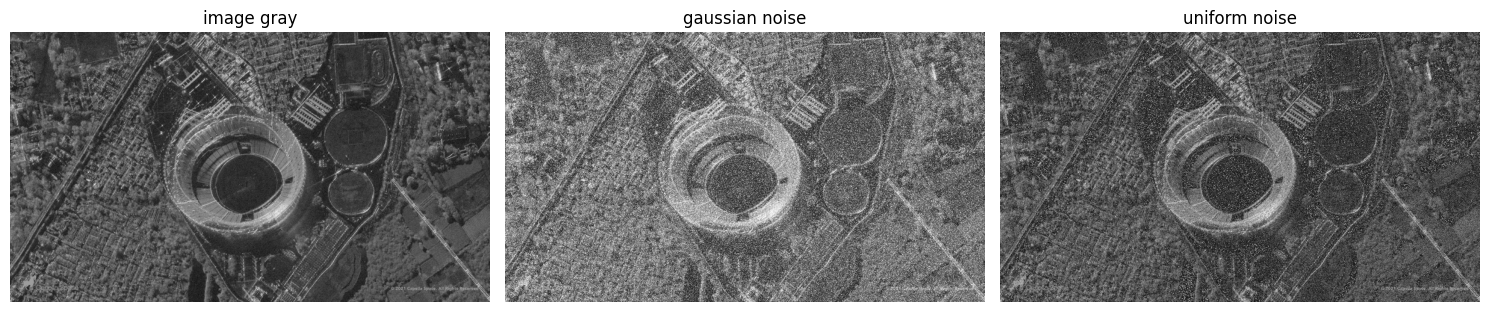

In [16]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
noise_gauss_image = cv2.add(image_gray, noise_gauss)

low = -50
high = 50
noise_uniform = np.random.uniform(low, high, image_gray.shape).astype(np.uint8)
noise_uniform_image = np.clip(image_gray.astype(np.uint8) + noise_uniform, 0, 255).astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('image gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(noise_gauss_image, cmap='gray'); plt.title('gaussian noise'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(noise_uniform_image, cmap='gray'); plt.title('uniform noise'); plt.axis('off')
plt.tight_layout()
plt.show()

### 3. Результаты фильтрации изображения, искажённого гауссовским шумом

-- Filters results: --
Gaussian 3x3 sigma=0: MSE=1904.31, SSIM=0.4408
Gaussian 5x5 sigma=0: MSE=1765.33, SSIM=0.4866
Gaussian 7x7 sigma=0: MSE=1722.05, SSIM=0.4930
Gaussian 3x3 sigma=1: MSE=1870.63, SSIM=0.4494
Gaussian 3x3 sigma=2: MSE=1851.59, SSIM=0.4455
Gaussian 5x5 sigma=1: MSE=1779.06, SSIM=0.4825
Gaussian 5x5 sigma=2: MSE=1737.88, SSIM=0.4733
Gaussian 7x7 sigma=1: MSE=1772.37, SSIM=0.4848
Gaussian 7x7 sigma=2: MSE=1727.39, SSIM=0.4682
Median 3x3: MSE=1036.65, SSIM=0.4286
Median 5x5: MSE=702.91, SSIM=0.4686
Median 7x7: MSE=678.96, SSIM=0.4325
Bilateral d=9 sigma=25: MSE=3790.71, SSIM=0.1816
Bilateral d=9 sigma=75: MSE=1841.43, SSIM=0.3143
Bilateral d=15 sigma=100: MSE=1585.75, SSIM=0.3376
NLM h=10: MSE=4235.77, SSIM=0.1873
NLM h=20: MSE=4231.90, SSIM=0.1877
NLM h=30: MSE=2946.48, SSIM=0.2535


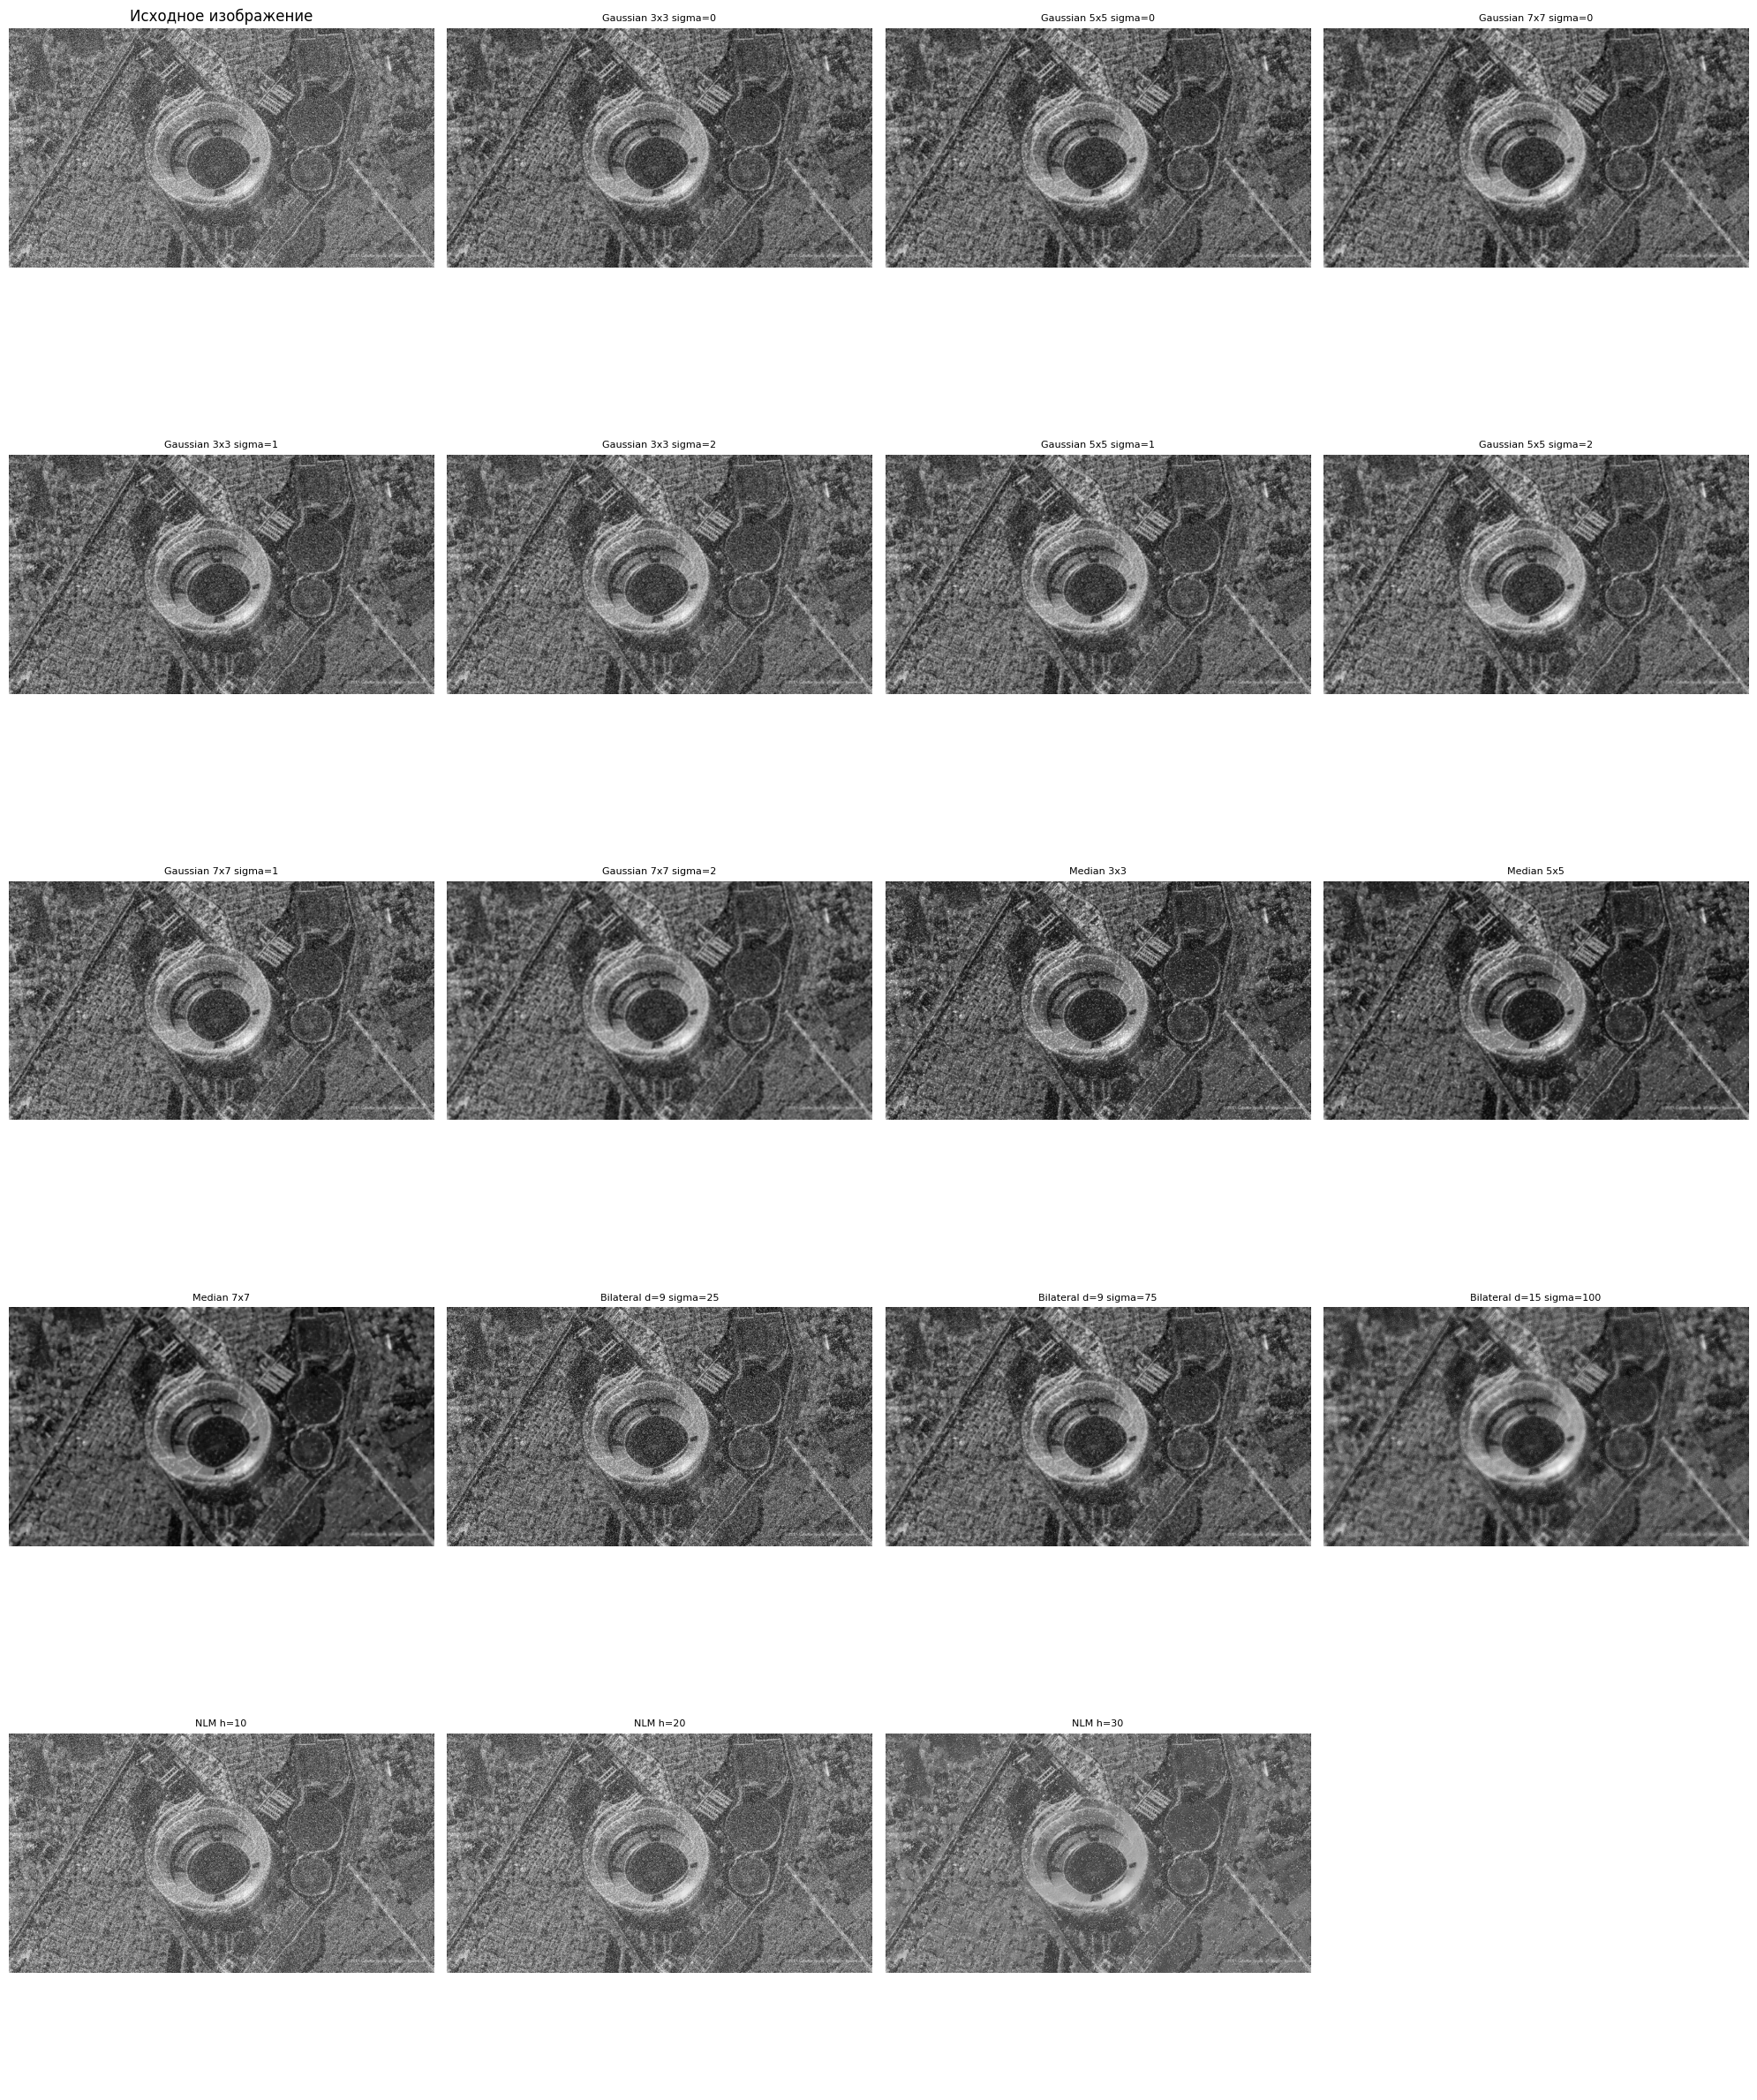

In [17]:
def filter_test(noisy_image, clean_image):
    filters_to_test = [
        ('Gaussian 3x3 sigma=0', cv2.GaussianBlur(noisy_image, (3, 3), 0)),
        ('Gaussian 5x5 sigma=0', cv2.GaussianBlur(noisy_image, (5, 5), 0)),
        ('Gaussian 7x7 sigma=0', cv2.GaussianBlur(noisy_image, (7, 7), 0)),
        ('Gaussian 3x3 sigma=1', cv2.GaussianBlur(noisy_image, (3, 3), 1)),
        ('Gaussian 3x3 sigma=2', cv2.GaussianBlur(noisy_image, (3, 3), 2)),
        ('Gaussian 5x5 sigma=1', cv2.GaussianBlur(noisy_image, (5, 5), 1)),
        ('Gaussian 5x5 sigma=2', cv2.GaussianBlur(noisy_image, (5, 5), 2)),
        ('Gaussian 7x7 sigma=1', cv2.GaussianBlur(noisy_image, (7, 7), 1)),
        ('Gaussian 7x7 sigma=2', cv2.GaussianBlur(noisy_image, (7, 7), 2)),

        ('Median 3x3', cv2.medianBlur(noisy_image, 3)),
        ('Median 5x5', cv2.medianBlur(noisy_image, 5)),
        ('Median 7x7', cv2.medianBlur(noisy_image, 7)),

        ('Bilateral d=9 sigma=25', cv2.bilateralFilter(noisy_image, 9, 25, 25)),
        ('Bilateral d=9 sigma=75', cv2.bilateralFilter(noisy_image, 9, 75, 75)),
        ('Bilateral d=15 sigma=100', cv2.bilateralFilter(noisy_image, 15, 100, 100)),

        ('NLM h=10', cv2.fastNlMeansDenoising(noisy_image, h=10)),
        ('NLM h=20', cv2.fastNlMeansDenoising(noisy_image, h=20)),
        ('NLM h=30', cv2.fastNlMeansDenoising(noisy_image, h=30))
    ]
    results = {}

    print("-- Filters results: --")

    for filter_name, filtered_image in filters_to_test:
        mse = mean_squared_error(clean_image, filtered_image)
        ssim = structural_similarity(clean_image, filtered_image)

        print(f"{filter_name}: MSE={mse:.2f}, SSIM={ssim:.4f}")

        results[filter_name] = {
            'image': filtered_image,
            'mse': mse,
            'ssim': ssim
        }
    return results

def visualize(noisy_image, results):
    n_filters = len(results)
    n_cols = 4
    n_rows = (n_filters + n_cols) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()

    axes[0].imshow(noisy_image, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')

    for idx, (filter_name, result) in enumerate(results.items(), 1):
        if idx < len(axes):
            axes[idx].imshow(result['image'], cmap='gray')
            axes[idx].set_title(f'{filter_name}', fontsize=8)
            axes[idx].axis('off')

    for idx in range(len(results) + 1, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

results = filter_test(noise_gauss_image, image_gray)
visualize(noise_gauss_image, results)

### 4. Сравнение фильтров по качеству восстановления изображения

Рейтинг фильтров по SSIM (чем выше SSIM, тем лучше):
1: Гаусса (7x7 sigma=0), MSE: 1722.05, SSIM: 0.4930
2: Гаусса (5x5 sigma=0), MSE: 1765.33, SSIM: 0.4866
3: Гаусса (7x7 sigma=1), MSE: 1772.37, SSIM: 0.4848
4: Гаусса (5x5 sigma=1), MSE: 1779.06, SSIM: 0.4825
5: Гаусса (5x5 sigma=2), MSE: 1737.88, SSIM: 0.4733
6: Медианный (5x5), MSE: 702.91, SSIM: 0.4686
7: Гаусса (7x7 sigma=2), MSE: 1727.39, SSIM: 0.4682
8: Гаусса (3x3 sigma=1), MSE: 1870.63, SSIM: 0.4494
9: Гаусса (3x3 sigma=2), MSE: 1851.59, SSIM: 0.4455
10: Гаусса (3x3 sigma=0), MSE: 1904.31, SSIM: 0.4408
11: Медианный (7x7), MSE: 678.96, SSIM: 0.4325
12: Медианный (3x3), MSE: 1036.65, SSIM: 0.4286
13: Билатеральный (d=15 sigma=100), MSE: 1585.75, SSIM: 0.3376
14: Билатеральный (d=9 sigma=75), MSE: 1841.43, SSIM: 0.3143
15: Cредних h=30, MSE: 2946.48, SSIM: 0.2535
16: Cредних h=20, MSE: 4231.90, SSIM: 0.1877
17: Cредних h=10, MSE: 4235.77, SSIM: 0.1873
18: Билатеральный (d=9 sigma=25), MSE: 3790.71, SSIM: 0.1816


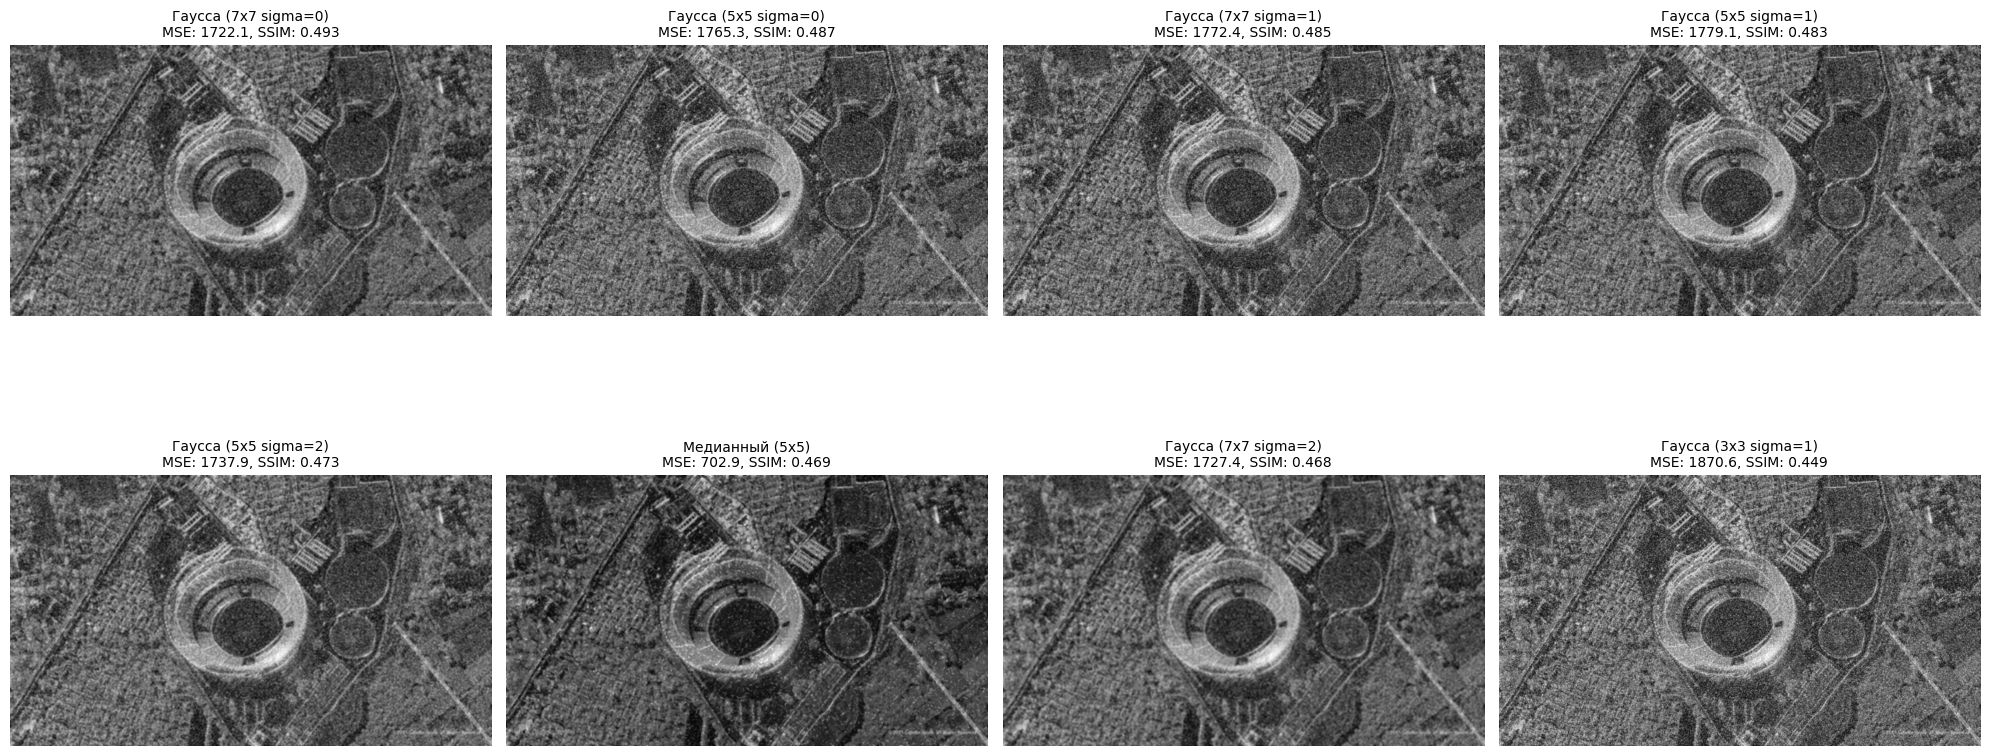


Лучший фильтр по MSE: Медианный (7x7)
MSE: 678.96 (чем меньше, тем лучше)

Лучший фильтр по SSIM: Гаусса (7x7 sigma=0)
SSIM: 0.4930 (чем ближе к 1, тем лучше)


In [18]:
from skimage.metrics import structural_similarity, mean_squared_error

def get_res(filter_img, clean_img) -> list:
    mse = mean_squared_error(clean_img, filter_img)
    ssim = structural_similarity(clean_img, filter_img)
    return [mse, ssim]

filtered_images = {
    'Гаусса (3x3 sigma=0)': cv2.GaussianBlur(noise_gauss_image, (3, 3), 0),
    'Гаусса (5x5 sigma=0)': cv2.GaussianBlur(noise_gauss_image, (5, 5), 0),
    'Гаусса (7x7 sigma=0)': cv2.GaussianBlur(noise_gauss_image, (7, 7), 0),
    'Гаусса (3x3 sigma=1)': cv2.GaussianBlur(noise_gauss_image, (3, 3), 1),
    'Гаусса (3x3 sigma=2)': cv2.GaussianBlur(noise_gauss_image, (3, 3), 2),
    'Гаусса (5x5 sigma=1)': cv2.GaussianBlur(noise_gauss_image, (5, 5), 1),
    'Гаусса (5x5 sigma=2)': cv2.GaussianBlur(noise_gauss_image, (5, 5), 2),
    'Гаусса (7x7 sigma=1)': cv2.GaussianBlur(noise_gauss_image, (7, 7), 1),
    'Гаусса (7x7 sigma=2)': cv2.GaussianBlur(noise_gauss_image, (7, 7), 2),

    'Медианный (3x3)': cv2.medianBlur(noise_gauss_image, 3),
    'Медианный (5x5)': cv2.medianBlur(noise_gauss_image, 5),
    'Медианный (7x7)': cv2.medianBlur(noise_gauss_image, 7),

    'Билатеральный (d=9 sigma=25)': cv2.bilateralFilter(noise_gauss_image, 9, 25, 25),
    'Билатеральный (d=9 sigma=75)': cv2.bilateralFilter(noise_gauss_image, 9, 75, 75),
    'Билатеральный (d=15 sigma=100)': cv2.bilateralFilter(noise_gauss_image, 15, 100, 100),

    'Cредних h=10': cv2.fastNlMeansDenoising(noise_gauss_image, h=10),
    'Cредних h=20': cv2.fastNlMeansDenoising(noise_gauss_image, h=20),
    'Cредних h=30': cv2.fastNlMeansDenoising(noise_gauss_image, h=30)
}

images_place = sorted(((k, get_res(v, image_gray)) for k, v in filtered_images.items()),
                     key=lambda x: x[1][1], reverse=True)

print("Рейтинг фильтров по SSIM (чем выше SSIM, тем лучше):")
for i, k in enumerate(images_place, 1):
    print(f'{i}: {k[0]}, MSE: {k[1][0]:.2f}, SSIM: {k[1][1]:.4f}')

plt.figure(figsize=(20, 10))
for i, (filter_name, metrics) in enumerate(images_place[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(filtered_images[filter_name], cmap='gray')
    plt.title(f'{filter_name}\nMSE: {metrics[0]:.1f}, SSIM: {metrics[1]:.3f}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

best_mse = min(images_place, key=lambda x: x[1][0])
best_ssim = max(images_place, key=lambda x: x[1][1])

print(f"\nЛучший фильтр по MSE: {best_mse[0]}")
print(f"MSE: {best_mse[1][0]:.2f} (чем меньше, тем лучше)")

print(f"\nЛучший фильтр по SSIM: {best_ssim[0]}")
print(f"SSIM: {best_ssim[1][1]:.4f} (чем ближе к 1, тем лучше)")